### Imports

In [ ]:
%pip install yfinance
%pip install matplotlib
%pip install scikit-learn
%pip install lxml

In [143]:
import pandas as pd
import numpy as np
import pickle as pkl
import requests
import copy
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm import tqdm
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from lightgbm import LGBMRegressor
from sklearn.model_selection._split import _BaseKFold

## Data collection

In [ ]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}
html = requests.get(url, headers=headers)
SPY_tickers = pd.read_html(html.text)[0]['Symbol'].tolist()
SPY_tickers.append("^GSPC")

In [ ]:
data = yf.download(SPY_tickers, start="2000-01-01", end="2025-11-25", auto_adjust=True)

In [ ]:
data.to_parquet("data/SPY_data.pq")

## Dataset creation

In [2]:
data = pd.read_parquet("data/SPY_data.pq")

In [3]:
# selected_stocks = data['Close'].columns.unique()[(data['Close'].isna().mean()<0.1)]

In [4]:
# len(selected_stocks)

In [5]:
data.columns.get_level_values(0).unique()

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [6]:
log_close = np.log(data['Close'])
log_open  = np.log(data['Open'])
log_high  = np.log(data['High'])
log_low   = np.log(data['Low'])

stocks = data['Close'].columns.unique()[:-1]
# stocks = selected_stocks[:-1]
index = '^GSPC'

# --- returns ---
close_diff = log_close[stocks].diff()
index_ret  = log_close[index].diff()

df = close_diff.mul(1e4).stack().rename("close_1d_ret").reset_index()

df["close_1d_ret_hedged"] = (
    (close_diff.sub(index_ret, axis=0) * 1e4)
    .stack()
    .values
)

# --- open-close ---
open_close = (log_close[stocks] - log_open[stocks]) * 1e4
open_close_idx = (log_close[index] - log_open[index]) * 1e4

df = df.merge(
    open_close.stack().rename("open_close_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (open_close.sub(open_close_idx, axis=0))
        .stack()
        .rename("open_close_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- close-open ---

close_open = (log_open[stocks] - log_close[stocks].shift()) * 1e4
close_open_idx = (log_open[index] - log_close[index].shift()) * 1e4

df = df.merge(
    close_open.stack().rename("close_open_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (close_open.sub(close_open_idx, axis=0))
        .stack()
        .rename("close_open_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- high-low ---
high_low = (log_high[stocks] - log_low[stocks]) * 1e4
high_low_idx = (log_high[index] - log_low[index]) * 1e4

df = df.merge(
    high_low.stack().rename("high_low_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (high_low.sub(high_low_idx, axis=0))
        .stack()
        .rename("high_low_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- volumes ---
volume = data['Volume'][stocks]
dollar_volume = volume * (data['Open'][stocks] + data['Close'][stocks])/2
dolar_volume_share = volume.div(volume.sum(axis=1), axis=0)

df = df.merge(
    volume.stack().rename("volume").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    dollar_volume.stack().rename("dollar_volume").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    dolar_volume_share.stack().rename("share_dollar_volume").reset_index(),
    on=["Date", "Ticker"]
)

In [7]:
df['body_ratio'] = df['open_close_ret'] / (df['high_low_ret']+1e-8)

In [8]:
df['turnover_proxy'] = df['dollar_volume'] / df.groupby('Date')['dollar_volume'].transform('mean')

In [9]:
df.set_index('Date', inplace=True)

In [ ]:
df['close_1d_ret_lag1'] = df.groupby('Ticker')['close_1d_ret'].shift()
df['close_1d_ret_hedged_lag1'] = df.groupby('Ticker')['close_1d_ret_hedged'].shift()
df['open_close_ret'] = df.groupby('Ticker')['open_close_ret'].shift()
df['open_close_ret_hedged'] = df.groupby('Ticker')['open_close_ret_hedged'].shift()
df['close_open_ret'] = df.groupby('Ticker')['close_open_ret'].shift()
df['close_open_ret_hedged'] = df.groupby('Ticker')['close_open_ret_hedged'].shift()
df['high_low_ret'] = df.groupby('Ticker')['high_low_ret'].shift()
df['high_low_ret_hedged'] = df.groupby('Ticker')['high_low_ret_hedged'].shift()
df['share_dollar_volume'] = df.groupby('Ticker')['share_dollar_volume'].shift()
df['body_ratio'] = df.groupby('Ticker')['body_ratio'].shift()
df['turnover_proxy'] = df.groupby('Ticker')['turnover_proxy'].shift()

In [11]:
df.tail()

,Ticker,close_1d_ret,close_1d_ret_hedged,open_close_ret,open_close_ret_hedged,close_open_ret,close_open_ret_hedged,high_low_ret,high_low_ret_hedged,volume,dollar_volume,share_dollar_volume,body_ratio,turnover_proxy,close_1d_ret_lag1,close_1d_ret_hedged_lag1
Date,,,,,,,,,,,,,,,,
2025-11-24,XYZ,-14.538433,-168.026622,-102.779030,-174.549343,102.779030,76.798313,551.886861,342.305225,7393600.0,4.579411e+08,0.003245,-0.186232,0.731647,0.000000,-97.751030
2025-11-24,YUM,-124.977450,-278.465639,205.389469,133.619155,44.135145,18.154428,232.154747,22.573111,3656900.0,5.535747e+08,0.000613,0.884709,0.334742,249.524614,151.773584
2025-11-24,ZBH,144.320589,-9.167600,297.280165,225.509851,45.926550,19.945833,398.187759,188.606124,2779100.0,2.587412e+08,0.000634,0.746583,0.208053,343.206715,245.455684
2025-11-24,ZBRA,62.060605,-91.427584,370.765291,298.994977,164.144503,138.163786,552.874732,343.293096,930100.0,2.251958e+08,0.000284,0.670614,0.243013,534.909794,437.158763
2025-11-24,ZTS,66.142011,-87.346178,476.520315,404.750001,42.192155,16.211439,533.773332,324.191696,7826900.0,9.568385e+08,0.001584,0.892739,0.683883,518.712470,420.961440


In [ ]:
linear_features = ['close_1d_ret_lag1', 'close_1d_ret_hedged_lag1', 'open_close_ret', 'open_close_ret_hedged', 'close_open_ret', 'close_open_ret_hedged', 'high_low_ret', 'high_low_ret_hedged', 'body_ratio']
non_linear_features = ['share_dollar_volume', 'turnover_proxy']

In [ ]:
with open("linear_features.pkl", "wb") as f:
    pkl.dump(linear_features, f)

with open("non_linear_features.pkl", "wb") as f:
    pkl.dump(non_linear_features, f)

In [14]:
df

,Ticker,close_1d_ret,close_1d_ret_hedged,open_close_ret,open_close_ret_hedged,close_open_ret,close_open_ret_hedged,high_low_ret,high_low_ret_hedged,volume,dollar_volume,share_dollar_volume,body_ratio,turnover_proxy,close_1d_ret_lag1,close_1d_ret_hedged_lag1
Date,,,,,,,,,,,,,,,,
2000-01-04,A,-794.644473,-403.652719,NaN,NaN,NaN,NaN,NaN,NaN,4765083.0,1.917209e+08,NaN,NaN,NaN,NaN,NaN
2000-01-04,AAPL,-880.774130,-489.782377,NaN,NaN,NaN,NaN,NaN,NaN,512377600.0,4.048177e+08,NaN,NaN,NaN,NaN,NaN
2000-01-04,ABT,-289.872231,101.119523,NaN,NaN,NaN,NaN,NaN,NaN,10734887.0,8.536908e+07,NaN,NaN,NaN,NaN,NaN
2000-01-04,ACGL,-54.500128,336.491626,NaN,NaN,NaN,NaN,NaN,NaN,84600.0,1.019541e+05,NaN,NaN,NaN,NaN,NaN
2000-01-04,ADBE,-876.181853,-485.190099,NaN,NaN,NaN,NaN,NaN,NaN,7813200.0,1.193387e+08,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-24,XYZ,-14.538433,-168.026622,-102.779030,-174.549343,102.779030,76.798313,551.886861,342.305225,7393600.0,4.579411e+08,0.003245,-0.186232,0.731647,0.000000,-97.751030
2025-11-24,YUM,-124.977450,-278.465639,205.389469,133.619155,44.135145,18.154428,232.154747,22.573111,3656900.0,5.535747e+08,0.000613,0.884709,0.334742,249.524614,151.773584
2025-11-24,ZBH,144.320589,-9.167600,297.280165,225.509851,45.926550,19.945833,398.187759,188.606124,2779100.0,2.587412e+08,0.000634,0.746583,0.208053,343.206715,245.455684


In [ ]:
df.to_parquet('df_base.pq')

# Baseline models

## Random Strategy

In [21]:
df = pd.read_parquet('df_base.pq')

In [32]:
np.random.seed(42)
df['random_signal'] = 0.0

def assign_random_signals(group):
    n = len(group)
    if n >= 70:
        signals = np.array([1.0] * 35 + [-1.0] * 35 + [0.0] * (n - 70))
        np.random.shuffle(signals)
        return pd.Series(signals, index=group.index)
    else:
        return pd.Series(0.0, index=group.index)

df['random_signal'] = df.groupby('Date', group_keys=False).apply(assign_random_signals)

In [33]:
random_daily_returns = df.groupby('Date').apply(lambda x: (x['random_signal']*x['close_1d_ret']).sum()/70)

<Axes: title={'center': 'Cumulative Random Strategy Return'}, xlabel='Date'>

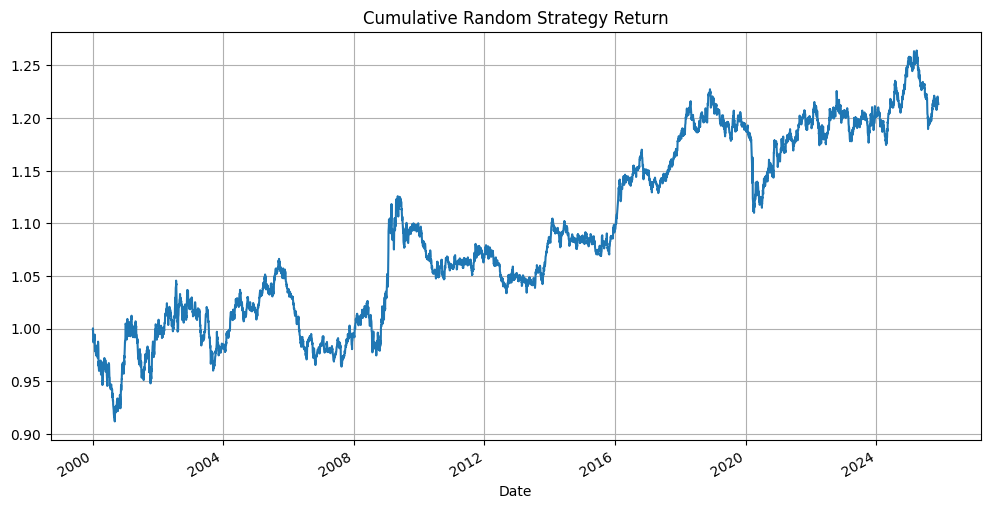

In [34]:
(random_daily_returns*1e-4+1).cumprod().plot(figsize=(12,6), title='Cumulative Random Strategy Return', grid=True)

In [35]:
random_daily_returns.mean()/random_daily_returns.std()*252**0.5

np.float64(0.21580421264586783)

## Momentum Strategies

In [36]:
df = pd.read_parquet('df_base.pq')

### Simple Momentum Strategy

In [37]:
def compute_signal(x):
    if x.notna().sum() == 0:
        return pd.Series([np.nan]*len(x), index=x.index)
    ranks = x.rank(method='first')
    binned = pd.cut(ranks, bins=10, labels=False, include_lowest=True)
    signal = binned.map(lambda y: -1 if y == 0 else (1 if y == 9 else 0))
    return signal

In [38]:
df['momentum_signal'] = df.groupby('Date')['close_1d_ret_lag1'].transform(compute_signal)

In [39]:
momentum_daily_returns = df.groupby('Date').apply(
    lambda x: (x['momentum_signal'] * x['close_1d_ret']).sum()/70
)*1e-4

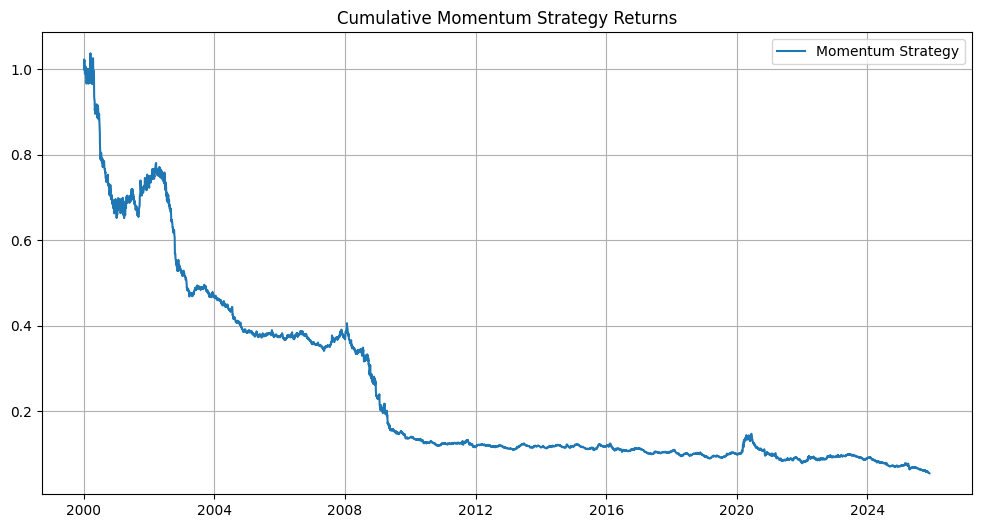

In [43]:
plt.figure(figsize=(12, 6))
plt.plot((momentum_daily_returns+1).cumprod(), label='Momentum Strategy')
plt.title('Cumulative Momentum Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [44]:
momentum_daily_returns.mean()/momentum_daily_returns.std()*np.sqrt(252)

np.float64(-0.7900419771683468)

In [45]:
monthly_returns = np.log(data['Close'].resample('MS').first()).diff().iloc[1:]

In [46]:
monthly_momentum_rank = monthly_returns.rank(method='first', axis=1)
monthly_momentum_bin = monthly_momentum_rank.apply(lambda row: pd.cut(row, bins=10, labels=False, include_lowest=True), axis=1)
monthly_momentum_signal = monthly_momentum_bin.map(lambda y: -1 if y == 0 else (1 if y == 9 else 0)).shift()

In [47]:
monthly_momentum_returns = (monthly_momentum_signal*monthly_returns).sum(1)/70

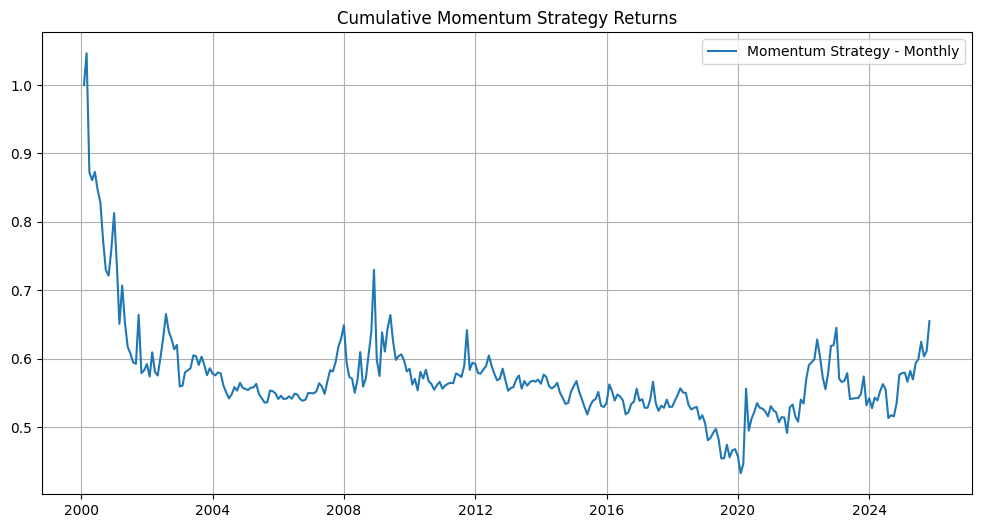

In [48]:
plt.figure(figsize=(12, 6))
plt.plot((monthly_momentum_returns+1).cumprod(), label='Momentum Strategy - Monthly')
plt.title('Cumulative Momentum Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [60]:
monthly_momentum_returns.mean()/monthly_momentum_returns.std()*np.sqrt(252)

np.float64(-0.20827302530801692)

### MACD Vol adjusted Strategy

In [51]:
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]

In [52]:
for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
    macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(63).std()
    macd_adj_series.name = f'macd_adj_{i+1}'
    df = df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
    df[f'macd_adj_{i+1}'] /= df[f'macd_adj_{i+1}'].rolling(252).std()

In [53]:
def phi_baz(x):
    return x / np.sqrt(1 + x**2)

In [54]:
df['macd_baz_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(phi_baz).sum(1).replace(0, np.nan)
df['macd_baz_signal'] = df.groupby('Date')['macd_baz_signal'].transform(compute_signal)

In [55]:
df['macd_tanh_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(np.tanh).sum(1).replace(0, np.nan)
df['macd_tanh_signal']  = df.groupby('Date')['macd_tanh_signal'].transform(compute_signal)

In [56]:
df['macd_baz_signal'] = df.groupby('Ticker')['macd_baz_signal'].shift()
df['macd_tanh_signal'] = df.groupby('Ticker')['macd_tanh_signal'].shift()

In [57]:
macd_daily_returns = df.groupby('Date').apply(
    lambda x: pd.Series({
        'baz': (x['macd_baz_signal'] * x['close_1d_ret']).sum()/70,
        'tanh': (x['macd_tanh_signal'] * x['close_1d_ret']).sum()/70
    })
)*1e-4

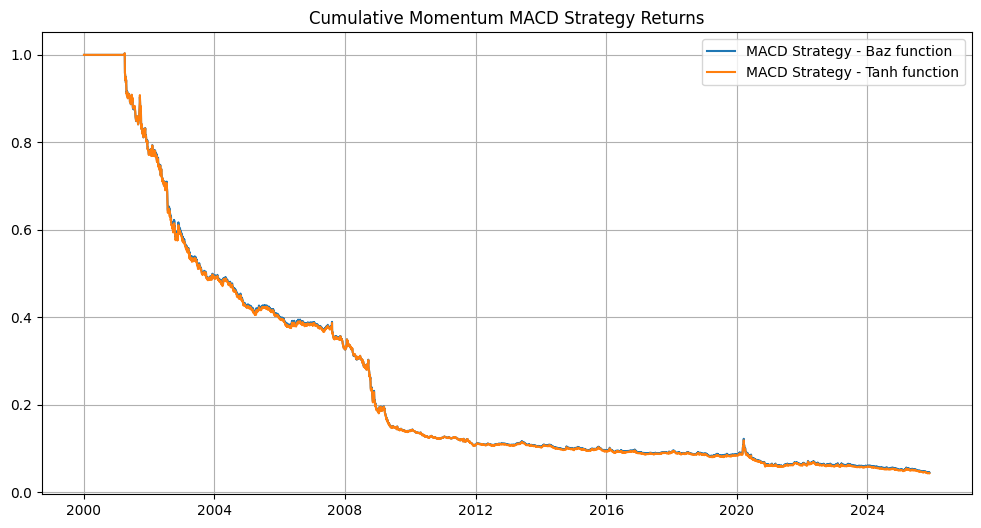

In [58]:
plt.figure(figsize=(12, 6))
plt.plot((macd_daily_returns['baz']+1).cumprod(), label='MACD Strategy - Baz function')
plt.plot((macd_daily_returns['tanh']+1).cumprod(), label='MACD Strategy - Tanh function')

plt.title('Cumulative Momentum MACD Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [59]:
macd_daily_returns.mean()/macd_daily_returns.std()*np.sqrt(252)

baz    -1.082408
tanh   -1.094185
dtype: float64

# Regress-then-rank Strategies 

In [61]:
df = pd.read_parquet('df_base.pq')

## Linear Regression

### Feature factory

In [62]:
with open("linear_features.pkl", "rb") as f:
    linear_features = pkl.load(f)

In [63]:
all_linear_features = copy.deepcopy(linear_features)

In [64]:
for feature in tqdm(linear_features):
    for h in [3, 5, 10, 15, 20, 30, 60, 80]:
        df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
        df[f'zscore_{feature}_{h}d'] = (df[feature]-df[f'avg_{feature}_{h}d'])/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
        df[f'sharpe_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
        all_linear_features.append(f'avg_{feature}_{h}d')
        all_linear_features.append(f'zscore_{feature}_{h}d')
        all_linear_features.append(f'sharpe_{feature}_{h}d')

 44%|████▍     | 4/9 [00:42<00:52, 10.56s/it]/tmp/ipykernel_166355/3641886625.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'sharpe_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
/tmp/ipykernel_166355/3641886625.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
/tmp/ipykernel_166355/3641886625.py:4: PerformanceWarning: DataFrame is highly fragmented.  T

In [65]:
df.to_parquet('df_all_features.pq')

In [66]:
with open("all_linear_features.pkl", "wb") as f:
    pkl.dump(all_linear_features, f)

### Article features

In [67]:
df = pd.read_parquet('df_base.pq')

In [68]:
article_features = []

feature = 'close_1d_ret'
for h in [3, 5, 20, 60]:
    df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
    df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[f'avg_{feature}_{h}d'].shift()
    df[f'vol_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())*np.sqrt(252)
    df[f'vol_{h}d'] = df.groupby('Ticker')[f'vol_{h}d'].shift()
    df[f'avg_normalised_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df[f'vol_{h}d']
    article_features.append(f'avg_{feature}_{h}d')
    article_features.append(f'avg_normalised_{feature}_{h}d')

#### Test for MACD Features

In [ ]:
test_df = df[['Ticker']]
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]
for window in tqdm([21, 63, 126, 252]):
    for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
        macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(63).std()
        macd_adj_series.name = f'macd_adj_first_{window}_{i+1}'
        test_df = test_df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
        test_df[f'macd_adj_first_{window}_{i+1}'] /= test_df[f'macd_adj_first_{window}_{i+1}'].rolling(window).std()

for window in tqdm([21, 63, 126, 252]):
    for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
        macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(window).std()
        macd_adj_series.name = f'macd_adj_second_{window}_{i+1}'
        test_df = test_df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
        test_df[f'macd_adj_second_{window}_{i+1}'] /= test_df[f'macd_adj_second_{window}_{i+1}'].rolling(252).std()

In [ ]:
test_df.drop(columns='Ticker').corr()

#### End

In [69]:
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]

for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
    macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(63).std()
    macd_adj_series.name = f'macd_adj_{i+1}'
    df = df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
    df[f'macd_adj_{i+1}'] /= df[f'macd_adj_{i+1}'].rolling(252).std()
    df[f'macd_adj_{i+1}'] = df.groupby('Ticker')[f'macd_adj_{i+1}'].shift()
    article_features.append(f'macd_adj_{i+1}')

In [70]:
def phi_baz(x):
    return x / np.sqrt(1 + x**2)

In [71]:
df['macd_baz_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(phi_baz).sum(1).replace(0, np.nan)
article_features.append('macd_baz_signal')

In [72]:
df[article_features].corr()

,avg_close_1d_ret_3d,avg_normalised_close_1d_ret_3d,avg_close_1d_ret_5d,avg_normalised_close_1d_ret_5d,avg_close_1d_ret_20d,avg_normalised_close_1d_ret_20d,avg_close_1d_ret_60d,avg_normalised_close_1d_ret_60d,macd_adj_1,macd_adj_2,macd_adj_3,macd_baz_signal
avg_close_1d_ret_3d,1.000000,0.114855,0.765642,0.545281,0.383271,0.318139,0.213141,0.191705,0.739663,0.667016,0.538634,0.662393
avg_normalised_close_1d_ret_3d,0.114855,1.000000,0.087811,0.130676,0.043803,0.055418,0.026496,0.032584,0.117263,0.105266,0.084453,0.112880
avg_close_1d_ret_5d,0.765642,0.087811,1.000000,0.711500,0.494627,0.407786,0.274889,0.245921,0.694607,0.728273,0.635699,0.711281
avg_normalised_close_1d_ret_5d,0.545281,0.130676,0.711500,1.000000,0.348050,0.436181,0.205395,0.254342,0.689502,0.719935,0.626121,0.749243
avg_close_1d_ret_20d,0.383271,0.043803,0.494627,0.348050,1.000000,0.811977,0.557069,0.480466,0.185606,0.464135,0.678393,0.464480
avg_normalised_close_1d_ret_20d,0.318139,0.055418,0.407786,0.436181,0.811977,1.000000,0.456023,0.554212,0.213221,0.530765,0.776427,0.546803
avg_close_1d_ret_60d,0.213141,0.026496,0.274889,0.205395,0.557069,0.456023,1.000000,0.841012,0.024189,0.082917,0.284334,0.117988
avg_normalised_close_1d_ret_60d,0.191705,0.032584,0.245921,0.254342,0.480466,0.554212,0.841012,1.000000,0.035479,0.106909,0.343621,0.151731
macd_adj_1,0.739663,0.117263,0.694607,0.689502,0.185606,0.213221,0.024189,0.035479,1.000000,0.871975,0.596364,0.842675
macd_adj_2,0.667016,0.105266,0.728273,0.719935,0.464135,0.530765,0.082917,0.106909,0.871975,1.000000,0.875274,0.953197


In [73]:
class Winsorizer(BaseEstimator, TransformerMixin):
    """
    Transformateur pour winsoriser les features.
    Les limites sont apprises sur le train set et appliquées au test set.
    """
    def __init__(self, lower=0.01, upper=0.01):
        self.lower = lower
        self.upper = upper
        self.lower_bounds_ = None
        self.upper_bounds_ = None
    
    def fit(self, X, y=None):
        """Apprend les limites de winsorisation sur X"""
        if isinstance(X, pd.DataFrame):
            self.lower_bounds_ = X.quantile(self.lower)
            self.upper_bounds_ = X.quantile(1 - self.upper)
            self.feature_names_ = X.columns
        else:
            # Pour numpy array
            self.lower_bounds_ = np.percentile(X, self.lower * 100, axis=0)
            self.upper_bounds_ = np.percentile(X, (1 - self.upper) * 100, axis=0)
        
        return self
    
    def transform(self, X):
        """Applique la winsorisation avec les limites apprises"""
        if self.lower_bounds_ is None or self.upper_bounds_ is None:
            raise ValueError("Winsorizer must be fitted before transform")
        
        X_copy = X.copy()
        
        if isinstance(X, pd.DataFrame):
            for col in X.columns:
                X_copy[col] = np.clip(X_copy[col], 
                                     self.lower_bounds_[col], 
                                     self.upper_bounds_[col])
        else:
            # Pour numpy array
            X_copy = np.clip(X_copy, self.lower_bounds_, self.upper_bounds_)
        
        return X_copy

In [74]:
X = df[article_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[article_features]
y = df[article_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()["close_1d_ret"]

split_date = X.index.unique()[int(X.index.nunique()*0.8)]

X_train = X.loc[X.index<split_date]
X_test = X.loc[X.index>=split_date]
y_train = y.loc[y.index<split_date]
y_test = y.loc[y.index>=split_date]

In [75]:
ols_baseline = Pipeline([
    ('winsorizer', Winsorizer(lower=0.001, upper=0.001)),
    ('reg', LinearRegression(fit_intercept=False))
])

In [76]:
ols_baseline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('winsorizer', ...), ('reg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,lower,0.001
,upper,0.001
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",False
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [77]:
X_train.columns

Index(['avg_close_1d_ret_3d', 'avg_normalised_close_1d_ret_3d',
       'avg_close_1d_ret_5d', 'avg_normalised_close_1d_ret_5d',
       'avg_close_1d_ret_20d', 'avg_normalised_close_1d_ret_20d',
       'avg_close_1d_ret_60d', 'avg_normalised_close_1d_ret_60d', 'macd_adj_1',
       'macd_adj_2', 'macd_adj_3', 'macd_baz_signal'],
      dtype='object')

In [78]:
ols_baseline.named_steps['reg'].coef_

array([ 1.24239891e-02, -1.19268312e+01, -7.11531327e-02, -3.25364112e+01,
        5.06737190e-02, -6.09849531e+01, -3.17614877e-01,  1.12462843e+03,
       -7.72546679e+00,  6.09949467e+00, -9.59002212e+00,  6.45751469e+00])

In [79]:
y_pred = ols_baseline.predict(X_test)

In [80]:
df_test = df[df.index>=split_date][article_features + ["Ticker", "close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret"]]
# df_test = df[df.index>=split_date].replace([-np.inf, np.inf], np.nan).dropna()

In [81]:
df_test['y_pred'] = y_pred

In [82]:
def compute_signal(x):
    if x.notna().sum() == 0:
        return pd.Series([np.nan]*len(x), index=x.index)
    ranks = x.rank(method='first')
    binned = pd.cut(ranks, bins=10, labels=False, include_lowest=True)
    signal = binned.map(lambda y: -1 if y == 0 else (1 if y == 9 else 0))
    return signal

In [83]:
df_test['ols_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)

In [84]:
ols_daily_returns = df_test.groupby('Date').apply(lambda x: (x['ols_signal']*x['close_1d_ret']).sum()/70)

<Axes: title={'center': 'Cumulative OLS Baseline Strategy Return'}, xlabel='Date'>

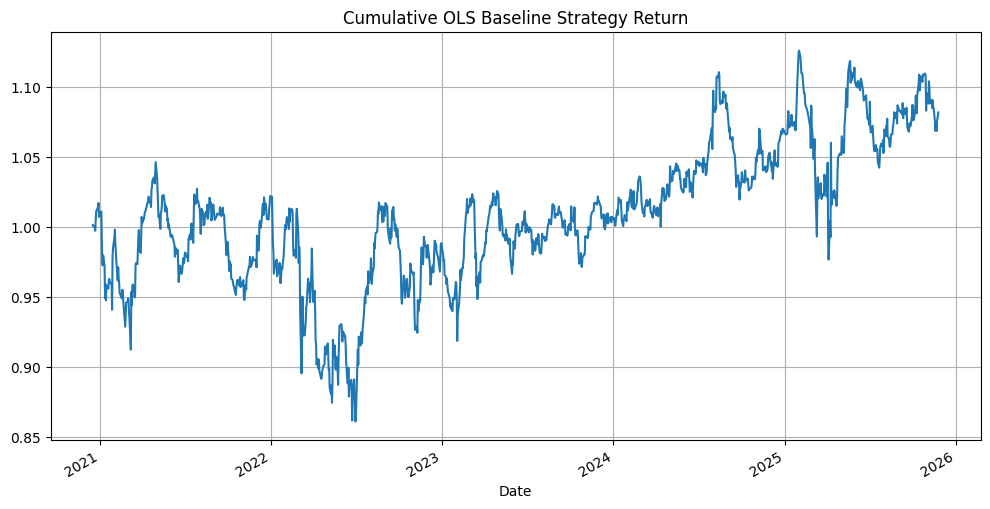

In [85]:
(ols_daily_returns*1e-4+1).cumprod().plot(figsize=(12,6), title='Cumulative OLS Baseline Strategy Return', grid=True)

In [86]:
ols_daily_returns.mean()/ols_daily_returns.std()*np.sqrt(252)

np.float64(0.184113872736329)

### All features

In [87]:
with open("all_linear_features.pkl", "rb") as f:
    all_linear_features = pkl.load(f)

In [88]:
df = pd.read_parquet('df_all_features.pq')

In [89]:
X = df[all_linear_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[all_linear_features]
y = df[all_linear_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()["close_1d_ret"]

split_date = X.index.unique()[int(X.index.nunique()*0.8)]

X_train = X.loc[X.index<split_date]
X_test = X.loc[X.index>=split_date]
y_train = y.loc[y.index<split_date]
y_test = y.loc[y.index>=split_date]

In [90]:
ols_baseline.fit(X_train.to_numpy(), y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('winsorizer', ...), ('reg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,lower,0.001
,upper,0.001
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",False
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [91]:
y_pred = ols_baseline.predict(X_test.to_numpy())
df_test = df[df.index>=split_date][all_linear_features + ["Ticker", "close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret"]]
df_test['y_pred'] = y_pred

In [92]:
df_test['ols_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)
ols_daily_returns = df_test.groupby('Date').apply(lambda x: (x['ols_signal']*x['close_1d_ret']).sum()/70)

<Axes: title={'center': 'Cumulative OLS all features Strategy Return'}, xlabel='Date'>

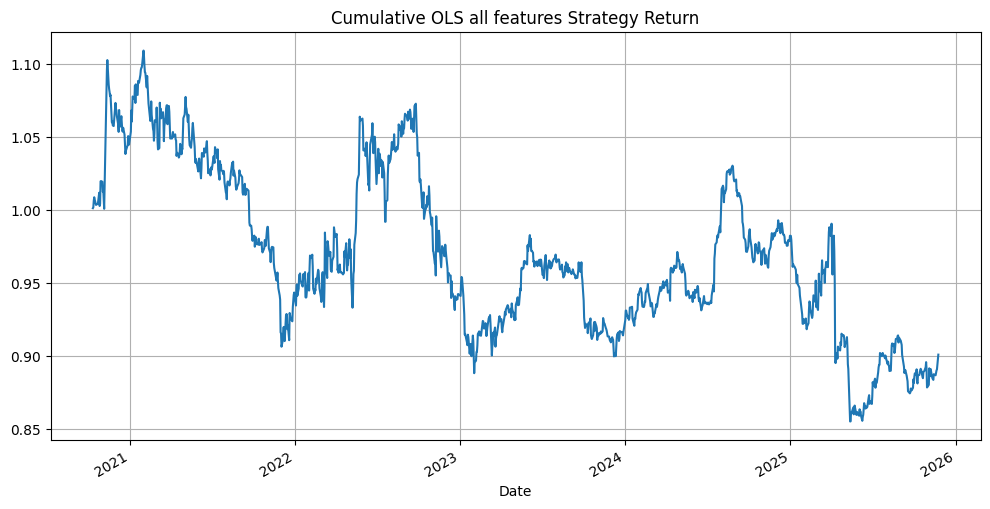

In [101]:
(ols_daily_returns*1e-4+1).cumprod().plot(figsize=(12,6), title='Cumulative OLS all features Strategy Return', grid=True)

In [102]:
ols_daily_returns.mean()/ols_daily_returns.std()*np.sqrt(252)

np.float64(-0.12809239366371503)

In [95]:
ols_pca = Pipeline([
    ('winsorizer', Winsorizer(lower=0.001, upper=0.001)),
    ('pca', PCA(n_components=0.95)),
    ('reg', LinearRegression(fit_intercept=False))
])

In [96]:
ols_pca.fit(X_train.to_numpy(), y_train)
y_pred_pca = ols_pca.predict(X_test.to_numpy())
df_test = df[df.index>=split_date][all_linear_features + ["Ticker", "close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret"]]
df_test['y_pred'] = y_pred_pca
df_test['ols_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)
ols_pca_daily_returns = df_test.groupby('Date').apply(lambda x: (x['ols_signal']*x['close_1d_ret']).sum()/70)

<Axes: title={'center': 'Cumulative OLS + PCA Strategy Return'}, xlabel='Date'>

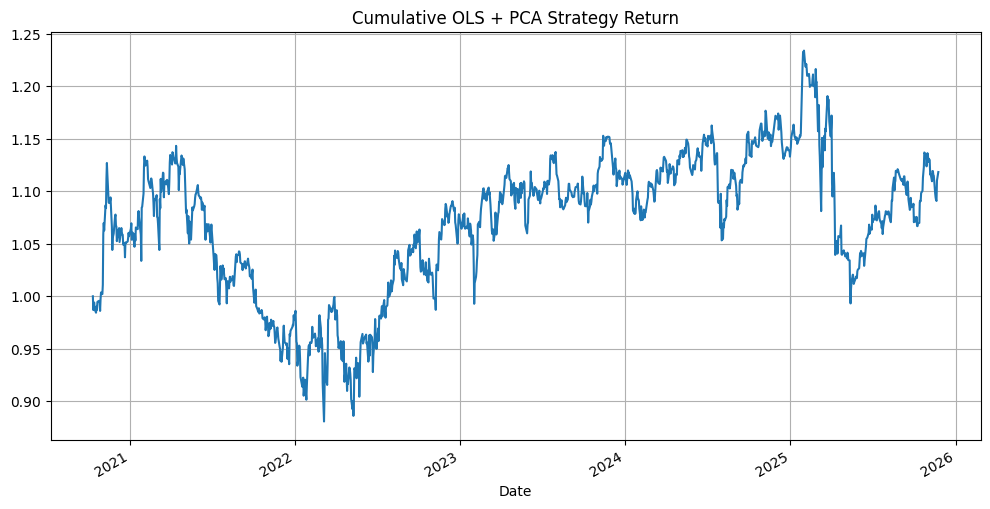

In [103]:
(ols_pca_daily_returns*1e-4+1).cumprod().plot(figsize=(12,6), title='Cumulative OLS + PCA Strategy Return', grid=True)

In [104]:
ols_pca_daily_returns.mean()/ols_pca_daily_returns.std()*np.sqrt(252)

np.float64(0.21766454002506697)

## LGBM Regressor

In [208]:
df = pd.read_parquet('df_all_features.pq')

#### Non linear features

In [209]:
with open("non_linear_features.pkl", "rb") as f:
    non_linear_features = pkl.load(f)

In [210]:
all_features = all_linear_features + non_linear_features

In [211]:
for window in tqdm([5, 10, 21, 42, 63, 126, 252]):
    df[f'vol_{window}d'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.rolling(window).std().shift())
    df[f'kurt_{window}d'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.rolling(window).kurt().shift())
    df[f'skew_{window}d'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.rolling(window).skew().shift())
    all_features.append(f'vol_{window}d')
    all_features.append(f'kurt_{window}d')
    all_features.append(f'skew_{window}d')
    if window>=10:
        df[f'vol_upside_{window}d'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.where(x>0, 0).rolling(window).std().shift())
        df[f'vol_downside_{window}d'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.where(x<0, 0).rolling(window).std().shift())
        all_features.append(f'vol_upside_{window}d')
        all_features.append(f'vol_downside_{window}d')

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:16<00:00,  2.36s/it]


#### End

In [212]:
len(all_features)

260

In [213]:
X = df[all_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[all_features]
y = df[all_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()["close_1d_ret"]

split_date = X.index.unique()[int(X.index.nunique()*0.8)]

X_train = X.loc[X.index<split_date]
X_test = X.loc[X.index>=split_date]
y_train = y.loc[y.index<split_date]
y_test = y.loc[y.index>=split_date]

In [214]:
lgbm = Pipeline([
    # ('scaler', StandardScaler()),
    # ('pca', PCA(n_components=0.95)),
    ('model', LGBMRegressor(
        objective="regression",
        boosting_type="gbdt",
        random_state=42,
        n_jobs=-1,
        force_col_wise=True 
    ))
])

In [215]:
%%time 
lgbm.fit(X_train, y_train)

CPU times: user 2min 55s, sys: 708 ms, total: 2min 56s
Wall time: 8.4 s


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'regression'


In [216]:
y_pred_lgbm = lgbm.predict(X_test)

In [217]:
df_test = df[df.index>=split_date][all_features + ["Ticker", "close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret"]]

In [218]:
df_test['y_pred'] = y_pred_lgbm

In [219]:
df_test['lgbm_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)
lgbm_daily_returns = df_test.groupby('Date').apply(lambda x: (x['lgbm_signal']*x['close_1d_ret']).sum()/70)

<Axes: title={'center': 'Cumulative LGBM Strategy Return'}, xlabel='Date'>

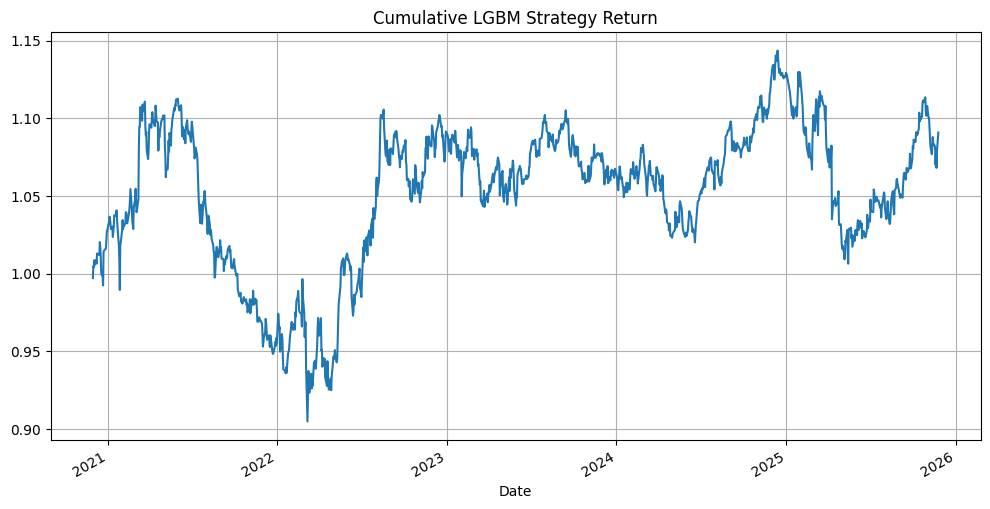

In [220]:
(lgbm_daily_returns*1e-4+1).cumprod().plot(figsize=(12,6), title='Cumulative LGBM Strategy Return', grid=True)

In [221]:
lgbm_daily_returns.mean()/lgbm_daily_returns.std()*np.sqrt(252)

np.float64(0.22140901603258287)

In [222]:
class ExpandingWindowCV(_BaseKFold):
    """
    Expanding Window Cross-Validator with fixed test size based on unique dates.
    
    This cross-validator creates splits where:
    - Split 1: Train on first 50% of unique dates, test on next 15% of unique dates
    - Split 2: Train on first 65% of unique dates, test on next 15% of unique dates
    - Split 3: Train on first 85% of unique dates, test on last 15% of unique dates
    
    The DataFrame is expected to be indexed by dates, with potentially multiple rows per date.
    The split is performed on unique dates, and all rows corresponding to dates in the 
    train/test periods are included in the respective sets.
    
    Parameters
    ----------
    n_splits : int, default=3
        Number of folds (fixed at 3 for this implementation)
    """
    
    def __init__(self, n_splits=3):
        super().__init__(n_splits=n_splits, shuffle=False, random_state=None)
        if n_splits != 3:
            raise ValueError("This implementation is designed for exactly 3 splits")
    
    def split(self, X, y=None, groups=None):
        """
        Generate indices to split data into training and test set based on unique dates.
        
        Parameters
        ----------
        X : pandas DataFrame with DatetimeIndex
            Training data indexed by dates
        y : array-like of shape (n_samples,), default=None
            Target variable
        groups : array-like of shape (n_samples,), default=None
            Group labels (not used)
            
        Yields
        ------
        train : ndarray
            The training set indices for that split
        test : ndarray
            The testing set indices for that split
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame with DatetimeIndex")
        
        if not isinstance(X.index, pd.DatetimeIndex):
            raise TypeError("X must have a DatetimeIndex")
        
        # Get unique dates and sort them
        unique_dates = pd.Series(X.index.unique()).sort_values().values
        n_unique_dates = len(unique_dates)
        
        # Define train/test boundaries as percentages of unique dates
        splits_config = [
            (0.50, 0.65),  # Train: 0-50%, Test: 50-65%
            (0.65, 0.80),  # Train: 0-65%, Test: 65-80%
            (0.85, 1.00),  # Train: 0-85%, Test: 85-100%
        ]
        
        for train_end_pct, test_end_pct in splits_config:
            train_end_idx = int(np.floor(train_end_pct * n_unique_dates))
            test_end_idx = int(np.floor(test_end_pct * n_unique_dates))
            
            # Get the date boundaries
            train_dates = unique_dates[:train_end_idx]
            test_dates = unique_dates[train_end_idx:test_end_idx]
            
            # Get all row indices corresponding to these dates
            train_indices = np.where(X.index.isin(train_dates))[0]
            test_indices = np.where(X.index.isin(test_dates))[0]
            
            yield train_indices, test_indices
    
    def get_n_splits(self, X=None, y=None, groups=None):
        """Returns the number of splitting iterations in the cross-validator"""
        return self.n_splits

In [223]:
cv = ExpandingWindowCV(n_splits=3)

In [224]:
param_distributions = {
    'model__num_leaves': [20, 31, 50, 75],
    'model__learning_rate': [0.005, 0.01, 0.03],
    'model__n_estimators': [100, 200, 300, 500],

    'model__min_child_samples': [50, 100, 150, 200, 500],
    'model__min_child_weight': [0.01, 0.1, 1],
    'model__reg_alpha': [0.1, 1, 5, 10],
    'model__reg_lambda': [0.1, 1, 5, 10],

    'model__subsample': [0.7, 0.8, 0.85],
    'model__subsample_freq': [1],
    'model__colsample_bytree': [0.7, 0.8, 0.85],

    'model__max_depth': [5, 7, 9],
}

In [227]:
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_distributions,
    n_iter=100,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=1,
    verbose=1,
    random_state=42
)

In [228]:
%%time
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
CPU times: user 18h 4min 25s, sys: 3min 47s, total: 18h 8min 13s
Wall time: 52min 3s


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'model__colsample_bytree': [0.7, 0.8, ...], 'model__learning_rate': [0.005, 0.01, ...], 'model__max_depth': [5, 7, ...], 'model__min_child_samples': [50, 100, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",100
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the var

In [229]:
with open("random_search.pkl", "wb") as f:
    pkl.dump(random_search, f)

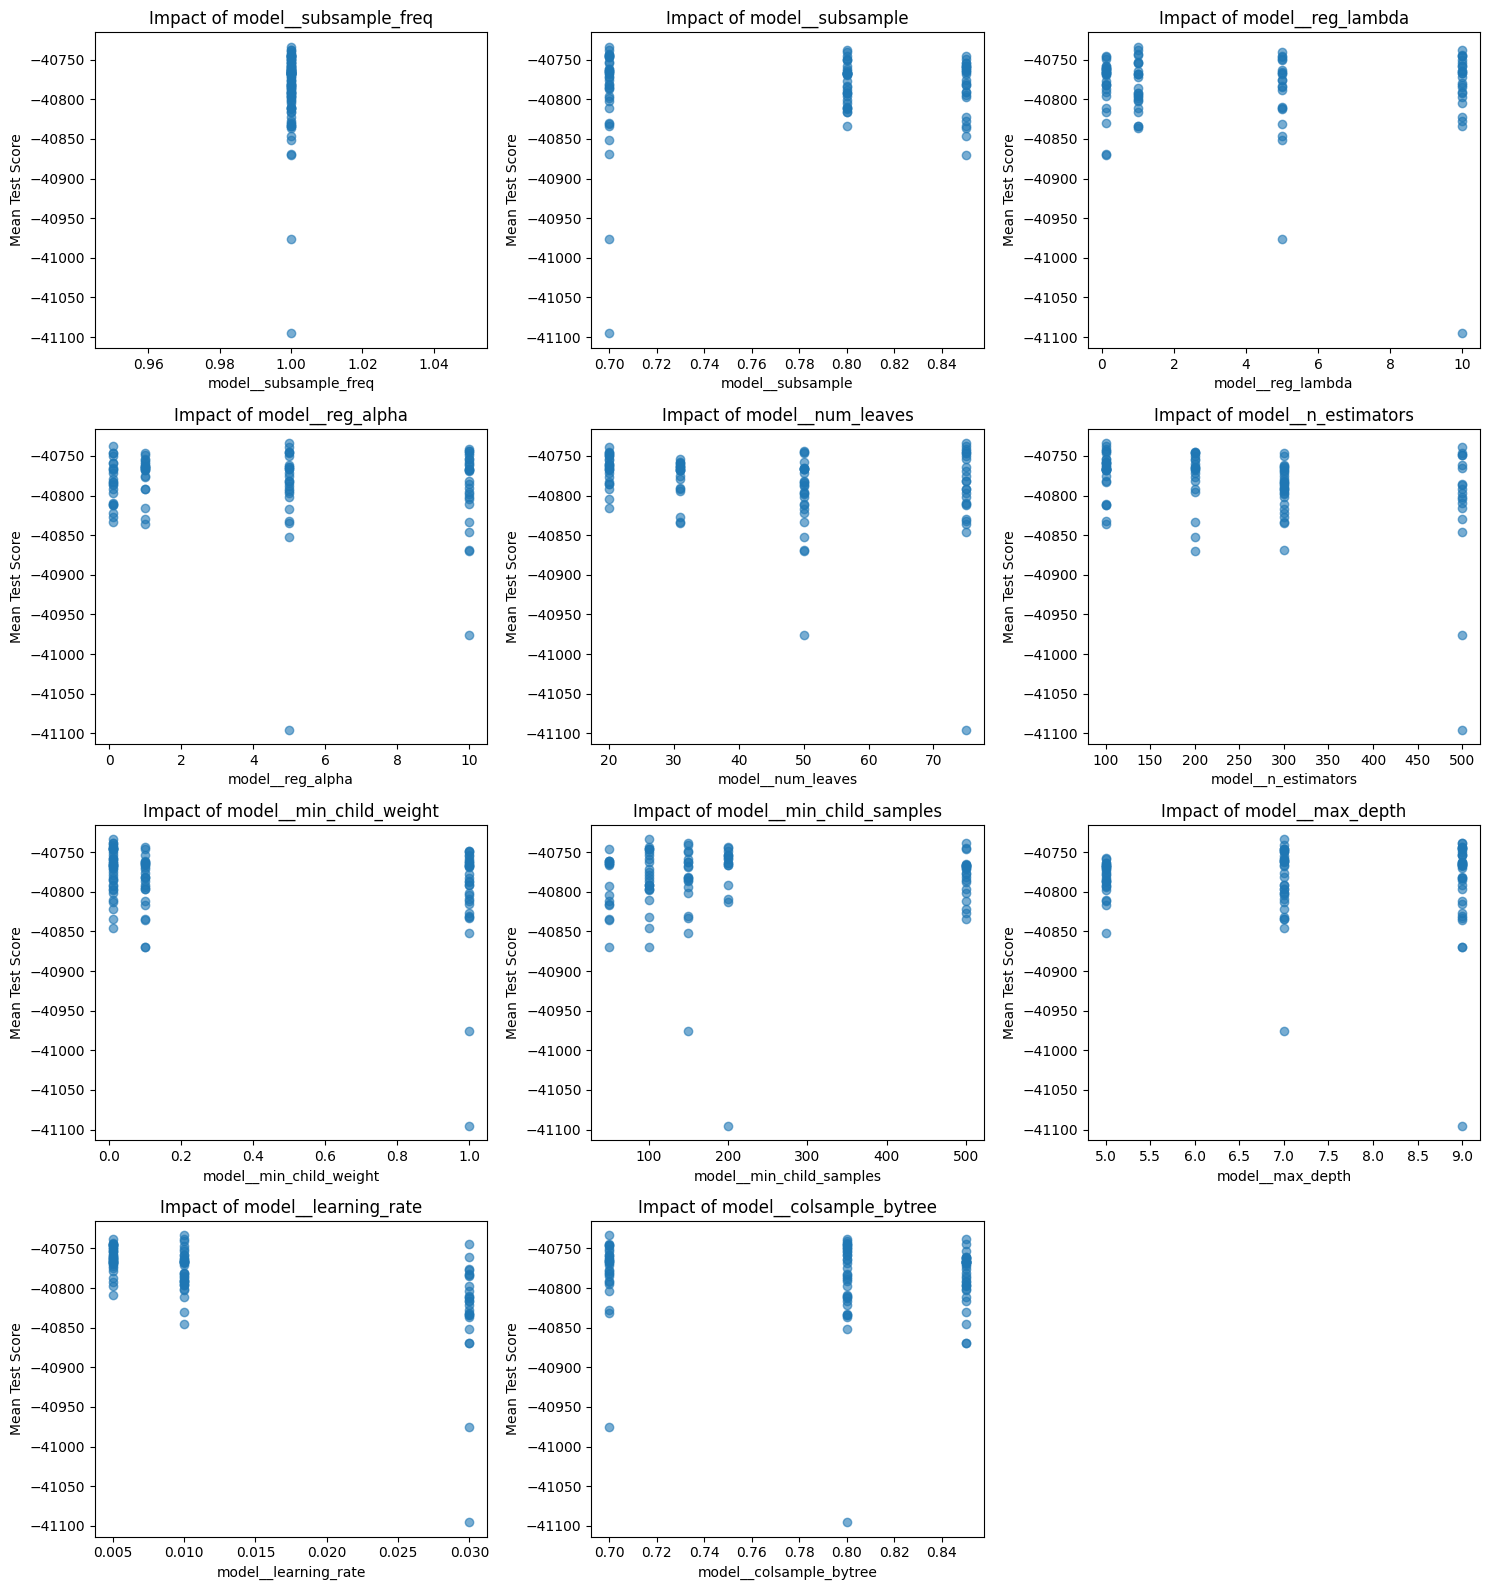

In [230]:
results_df = pd.DataFrame(random_search.cv_results_)

# Extract parameter columns
param_cols = [col for col in results_df.columns if col.startswith('param_')]

# Create clean dataframe
plot_df = results_df[param_cols + ['mean_test_score', 'std_test_score']].copy()
plot_df.columns = [col.replace('param_', '') for col in plot_df.columns]

# Parameters to plot
params = [col for col in plot_df.columns if col not in ['mean_test_score', 'std_test_score']]
n_params = len(params)

# Dynamic subplot grid
n_cols = 3
n_rows = math.ceil(n_params / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, param in enumerate(params):
    ax = axes[idx]
    ax.scatter(plot_df[param], plot_df['mean_test_score'], alpha=0.6)
    ax.set_xlabel(param)
    ax.set_ylabel('Mean Test Score')
    ax.set_title(f'Impact of {param}')

# Remove unused subplots
for idx in range(len(params), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

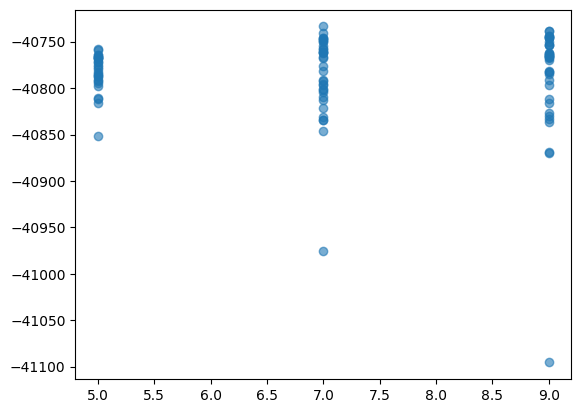

In [243]:
param = 'model__max_depth'

plt.scatter(plot_df[param], plot_df['mean_test_score'], alpha=0.6)

In [244]:
second_param_distributions = {
    'model__num_leaves': [10, 20, 31, 100],
    'model__learning_rate': [0.001, 0.005, 0.01],
    'model__n_estimators': [100, 150, 200, 250,],

    'model__min_child_samples': [100, 200, 500, 750],
    'model__min_child_weight': [0.1, 0.3, 0.5],
    'model__reg_alpha': [0.1, 0.3, 0.5, 1],
    'model__reg_lambda': [0.1, 1, 3, 5, 10],

    'model__subsample': [0.75, 0.8, 0.85, 0.9],
    'model__subsample_freq': [1],
    'model__colsample_bytree': [0.5, 0.6, 0.7, 0.8],

    'model__max_depth': [3, 5, 7, 10],
}

In [245]:
second_random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=second_param_distributions,
    n_iter=100,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=1,
    verbose=1,
    random_state=42
)

In [246]:
second_random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'model__colsample_bytree': [0.5, 0.6, ...], 'model__learning_rate': [0.001, 0.005, ...], 'model__max_depth': [3, 5, ...], 'model__min_child_samples': [100, 200, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",100
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the v

In [247]:
with open("second_random_search.pkl", "wb") as f:
    pkl.dump(second_random_search, f)

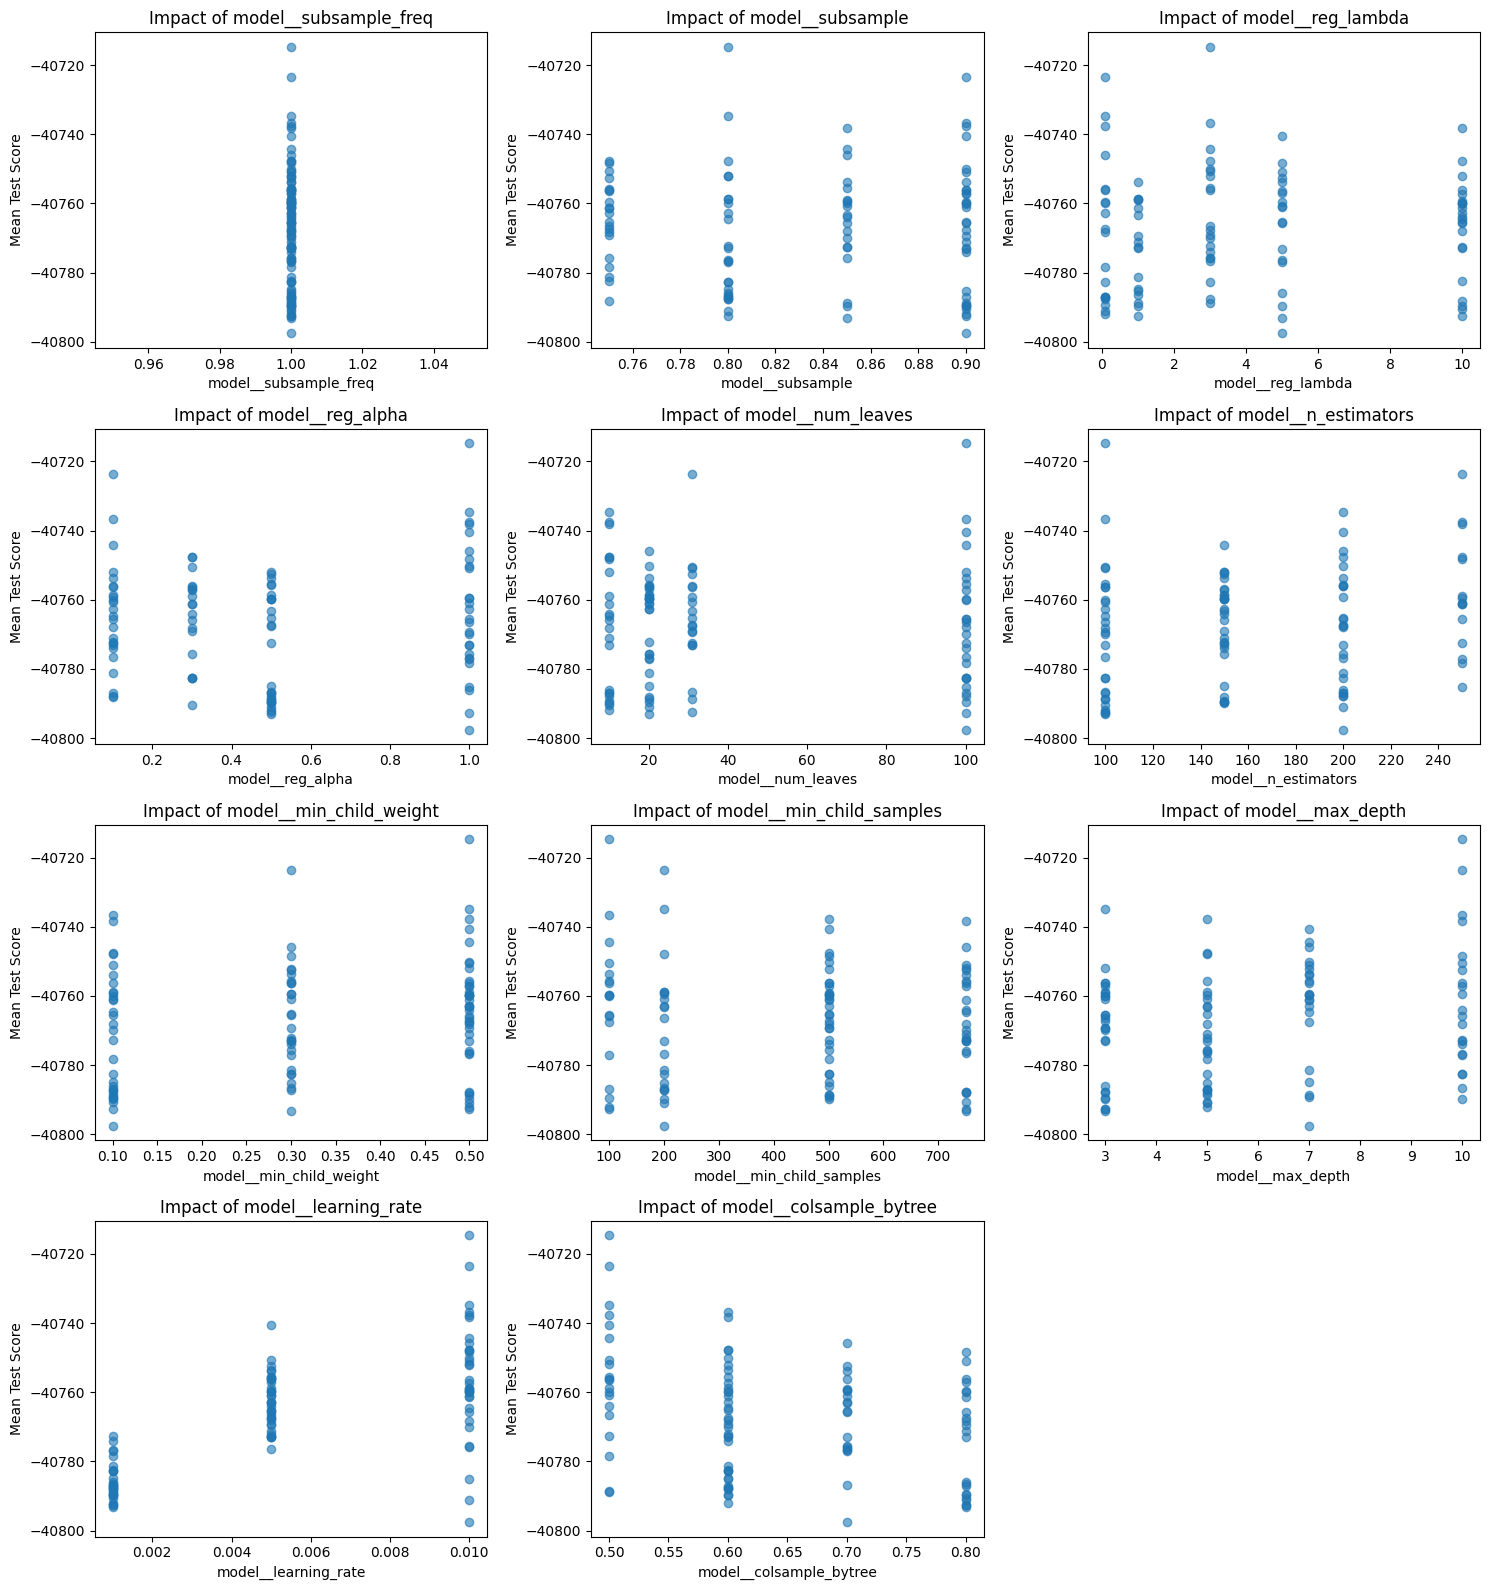

In [248]:
results_df = pd.DataFrame(second_random_search.cv_results_)

# Extract parameter columns
param_cols = [col for col in results_df.columns if col.startswith('param_')]

# Create clean dataframe
plot_df = results_df[param_cols + ['mean_test_score', 'std_test_score']].copy()
plot_df.columns = [col.replace('param_', '') for col in plot_df.columns]

# Parameters to plot
params = [col for col in plot_df.columns if col not in ['mean_test_score', 'std_test_score']]
n_params = len(params)

# Dynamic subplot grid
n_cols = 3
n_rows = math.ceil(n_params / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, param in enumerate(params):
    ax = axes[idx]
    ax.scatter(plot_df[param], plot_df['mean_test_score'], alpha=0.6)
    ax.set_xlabel(param)
    ax.set_ylabel('Mean Test Score')
    ax.set_title(f'Impact of {param}')

# Remove unused subplots
for idx in range(len(params), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [263]:
lgbm = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('model', LGBMRegressor(
        objective="regression",
        boosting_type="gbdt",
        random_state=42,
        n_jobs=-1,
        force_col_wise=True,
        num_leaves=31,
        learning_rate=0.005,
        n_estimators=250,
        min_child_samples=100,
        min_child_weight=0.5,
        reg_alpha=0.1,
        reg_lambda=3,
        subsample=0.75,
        subsample_freq=1,
        colsample_bytree=0.5,
        max_depth=10
    ))
])

In [264]:
%%time 
lgbm.fit(X_train, y_train)

CPU times: user 2min 24s, sys: 2.87 s, total: 2min 27s
Wall time: 15.1 s


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('pca', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",0.95
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True
,"whiten whiten: bool, default=FalseWhen True (False by default) the `components_` vectors are multipliedby the square root of n_samples and then divided by the singular valuesto ensure uncorrelated outputs with unit component-wise variances.Whitening will remove some information from the transformed signal(the relative variance scales of the components) but can sometimeimprove the predictive accuracy of the downstream estimators bymaking their data respect some hard-wired assumptions.",False
,"svd_solver svd_solver: {'auto', 

In [265]:
y_pred_lgbm = lgbm.predict(X_test)
df_test = df[df.index>=split_date][all_features + ["Ticker", "close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret"]]
df_test['y_pred'] = y_pred_lgbm
df_test['lgbm_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)
lgbm_daily_returns = df_test.groupby('Date').apply(lambda x: (x['lgbm_signal']*x['close_1d_ret']).sum()/70)

/opt/python/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


<Axes: title={'center': 'Cumulative custom LGBM Strategy Return'}, xlabel='Date'>

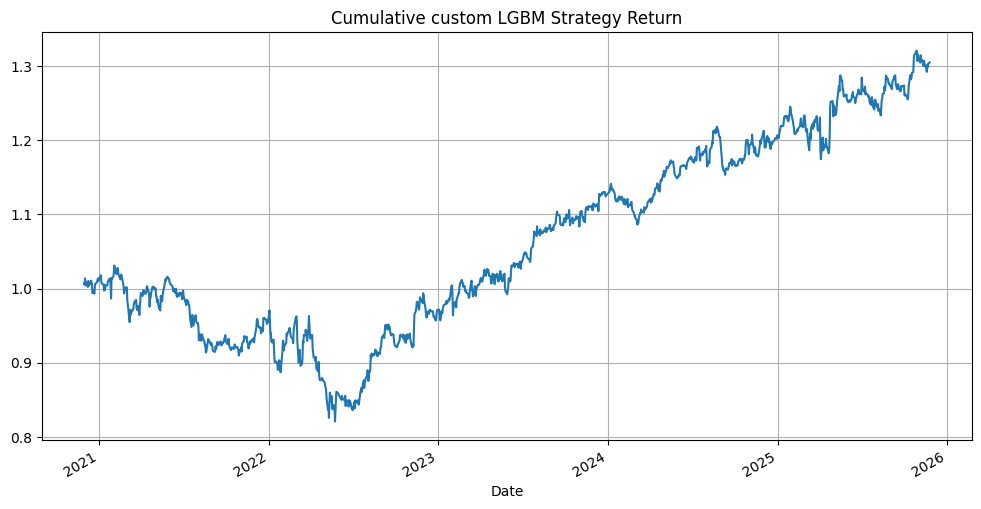

In [266]:
(1+lgbm_daily_returns*1e-4).cumprod().plot(figsize=(12,6), title='Cumulative custom LGBM Strategy Return', grid=True)

In [267]:
lgbm_daily_returns.mean()/lgbm_daily_returns.std()*np.sqrt(252)

np.float64(0.5637717851992435)

# LTR Strategies

## LambdaMART

In [157]:
import lightgbm as lgb

In [158]:
X = df[all_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[all_features]
y = df[all_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()["close_1d_ret"]

split_date = X.index.unique()[int(X.index.nunique()*0.8)]

X_train = X.loc[X.index<split_date]
X_test = X.loc[X.index>=split_date]
y_train = y.loc[y.index<split_date]
y_test = y.loc[y.index>=split_date]

In [159]:
pd.set_option('display.max_columns', None)

In [160]:
def convert_to_group_ranks(y_series):
    ranks = y_series.groupby(level=0).rank(method='first', ascending=True) - 1
    return ranks.astype(int)

y_train_ranks = convert_to_group_ranks(y_train)
y_test_ranks = convert_to_group_ranks(y_test)

In [161]:
train_groups = X_train.groupby('Date').size().values
test_groups = X_test.groupby('Date').size().values

In [162]:
max_label = max(y_train_ranks.max(), y_test_ranks.max())
label_gain = list(range(max_label + 1))

In [173]:
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'verbose': -1,
    'random_state': 42,
    'label_gain': label_gain
}

In [174]:
train_data = lgb.Dataset(X_train.values, label=y_train_ranks.values, group=train_groups)

In [175]:
model = lgb.train(
    params,
    train_data,
)

In [176]:
model.predict(X_test.values)

array([-0.04906744,  0.03672964, -0.14930489, ..., -0.21427328,
       -0.24440542, -0.22466296], shape=(612064,))

In [ ]:
test_scores = model.predict(X_test.values)
X_test_scored = X_test.copy()
X_test_scored['score'] = test_scores
X_test_scored['actual_return'] = y_test

In [178]:
def select_long_short(group, n_long=35, n_short=35):
    """Sélectionne les top n_long et bottom n_short par score"""
    group_sorted = group.sort_values('score', ascending=False)
    
    long_ret = group_sorted.head(n_long)['actual_return'].mean()
    short_ret = group_sorted.tail(n_short)['actual_return'].mean()
    
    return pd.Series({
        'long_ret': long_ret,
        'short_ret': short_ret,
        'ls_ret': long_ret - short_ret,
        'n_stocks': len(group)
    })

# Appliquer le groupby par date (level=0 car Date est l'index)
results_df = X_test_scored.groupby(level=0).apply(select_long_short, n_long=35, n_short=35)

<Axes: xlabel='Date'>

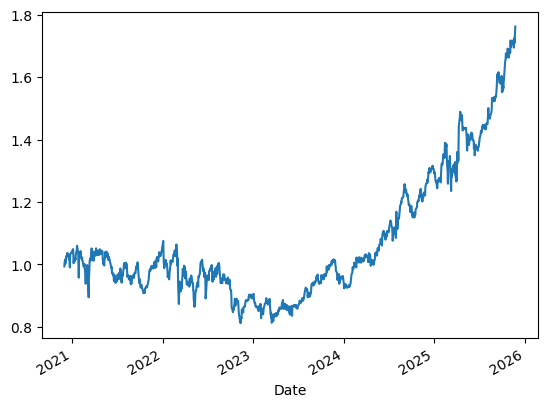

In [179]:
(1+results_df['ls_ret']*1e-4).cumprod().plot()

In [180]:
results_df['ls_ret'].mean()/results_df['ls_ret'].std()*np.sqrt(252)

np.float64(0.6669208709436527)

In [181]:
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'verbose': -1,
    'random_state': 42,
    'label_gain': label_gain,
    'n_jobs': -1,
    'num_leaves': 50,
    'learning_rate': 0.01,
    'n_estimators': 150,
    'min_child_samples': 100,
    'min_child_weight': 0.3,
    'reg_alpha': 3,
    'reg_lambda': 1,
    'subsample': 0.75,
    'subsample_freq': 1,
    'colsample_bytree': 0.6,
    'max_depth': 10
}

In [182]:
model = lgb.train(
    params,
    train_data,
)

In [183]:
test_scores = model.predict(X_test.values)
X_test_scored = X_test.copy()
X_test_scored['score'] = test_scores
X_test_scored['actual_return'] = y_test

In [184]:
results_df = X_test_scored.groupby(level=0).apply(select_long_short, n_long=35, n_short=35)

<Axes: xlabel='Date'>

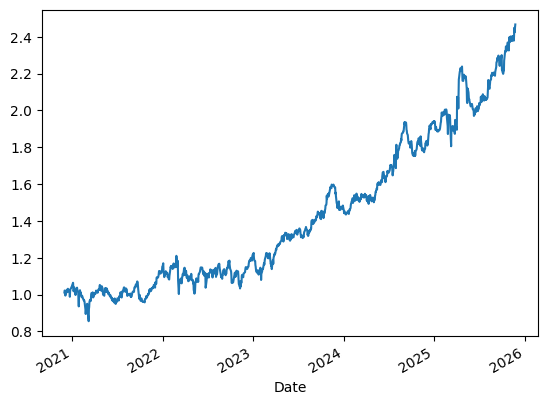

In [185]:
(1+results_df['ls_ret']*1e-4).cumprod().plot()

In [186]:
results_df['ls_ret'].mean()/results_df['ls_ret'].std()*np.sqrt(252)

np.float64(0.9873933849450317)

In [187]:
preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalisation (important pour PCA)
    ('pca', PCA(n_components=0.95))  # Garde 95% de la variance
])

In [188]:
X_train_pca = preprocessing_pipeline.fit_transform(X_train)
X_test_pca = preprocessing_pipeline.transform(X_test)

In [194]:
train_groups = X_train.groupby(level=0).size().values
test_groups = X_test.groupby(level=0).size().values

In [195]:
train_data = lgb.Dataset(X_train_pca, label=y_train_ranks.values, group=train_groups)

In [196]:
model = lgb.train(
    params,
    train_data,
)

In [205]:
test_scores = model.predict(X_test_pca)
X_test_pca_scored = pd.DataFrame(X_test_pca)
X_test_pca_scored.index = X_test.index
X_test_pca_scored['score'] = test_scores
X_test_pca_scored['actual_return'] = y_test
results_df = X_test_pca_scored.groupby(level=0).apply(select_long_short, n_long=35, n_short=35)

<Axes: xlabel='Date'>

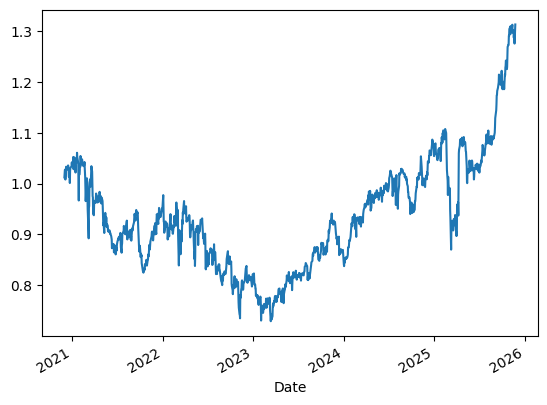

In [206]:
(1+results_df['ls_ret']*1e-4).cumprod().plot()

In [207]:
results_df['ls_ret'].mean()/results_df['ls_ret'].std()*np.sqrt(252)

np.float64(0.3649503325478279)